In [1]:
# Installing dependencies
# !pip install tensorflow==2.4.0  tensorflow-gpu==2.4.0  opencv-python matplotlib 

In [2]:
# Import Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt 

In [3]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [5]:
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [10]:
# Uncompress Tar GZ labeled faces in the wild dataset
!tar -xf lfw.tgz
# This going to extract the data and put it to the same repository


In [11]:
# Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
        

In [5]:
# Import UUID library to generate unique image names
import uuid

In [13]:
# uuid.uuid1()
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4c952b81-3925-11ef-9dea-f702c96fc582.jpg'

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[200:200+250, 250:250+250, :]

    # Collect anchor
    if cv2.waitKey(1) & 0XFF ==ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect positive
    if cv2.waitKey(1) & 0XFF ==ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show figure
cv2.destroyAllWindows()


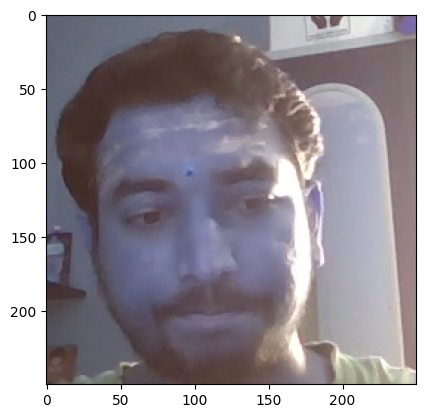

In [8]:
plt.imshow(frame)
# frame[:250, :250, :].shape
# plt.imshow(frame[200:200+250, 250:250+250, :])

In [123]:
# Get Image Directories

anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(300)

In [39]:
dit_test = anchor.as_numpy_iterator()

In [7]:
dit_test.next()

b'data\\anchor\\augmented_190.jpg'

In [8]:
print(anchor)

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [109]:
# Preprocessing

def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100px
    img = tf.image.resize(img, (100,100))
    # Scaling the image to be between 0 and 1, changing the pixel value of the image
    # img = img/255.0

    # Return img
    return img

In [41]:
img = preprocess('data\\anchor\\augmented_239.jpg')

In [78]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.09019608, 0.04901961, 0.08921569],
        [0.06960785, 0.05      , 0.06764706],
        [0.07745098, 0.08529412, 0.06764706],
        ...,
        [0.02843137, 0.04019608, 0.03627451],
        [0.04117647, 0.05294118, 0.04901961],
        [0.02352941, 0.03529412, 0.03137255]],

       [[0.10882353, 0.08529412, 0.08921569],
        [0.09705883, 0.0872549 , 0.07352941],
        [0.10588235, 0.11372549, 0.08039216],
        ...,
        [0.05686275, 0.05294118, 0.05490196],
        [0.05392157, 0.05      , 0.05196078],
        [0.05098039, 0.04705882, 0.04901961]],

       [[0.08627451, 0.08039216, 0.0627451 ],
        [0.08431373, 0.08039216, 0.0627451 ],
        [0.10588235, 0.10588235, 0.08333334],
        ...,
        [0.04509804, 0.04117647, 0.04313726],
        [0.05      , 0.04607843, 0.04803922],
        [0.03921569, 0.03529412, 0.0372549 ]],

       ...,

       [[0.35784313, 0.20490196, 0.14411765],
        [0.32

In [42]:
img.numpy().max()

0.9852941

In [24]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
tf.ones(5)
# tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# Putting the data into data folders

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [43]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [44]:
samples = data.as_numpy_iterator()
example = samples.next()
np.array(data).shape


()

In [45]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [46]:
res = preprocess_twin(*example)

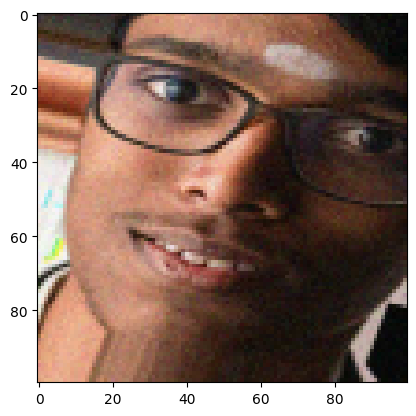

In [47]:
plt.imshow(res[0])

In [48]:
# Build data loader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [49]:
samples = data.as_numpy_iterator()

In [50]:
len(samples.next())

3

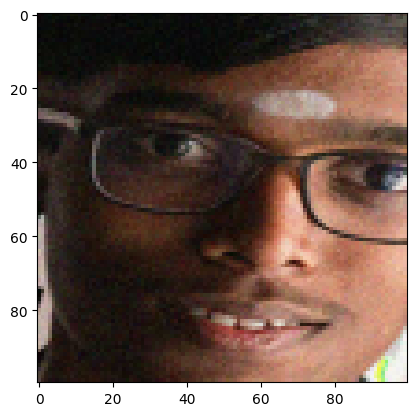

In [51]:
samp = samples.next()
plt.imshow(samp[0])


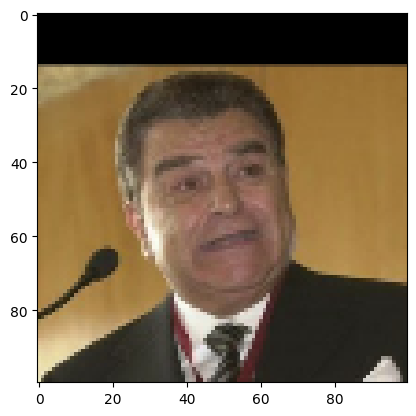

In [52]:
plt.imshow(samp[1])

In [53]:
samp[2]

0.0

In [54]:
len(data)

600

In [55]:
round(len(data)*.7)

420

In [56]:
16 * 26

416

In [57]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [58]:
train_sample = train_data.as_numpy_iterator()


In [59]:
train_sample = train_sample.next()

In [60]:
x = train_sample[:2]

In [61]:
np.array(x).shape

(2, 16, 100, 100, 3)

In [62]:
# Testing Partition
round(len(data)*.3)

180

In [63]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [64]:
# Model Engineering

In [65]:
# Build Embedding Layer
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'Input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [66]:
embedding = make_embedding()

In [122]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Build Distance Layer

In [69]:
# Siamense L1 Distance Class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [70]:
# Make Siamense Layer

In [71]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [72]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_53>]

In [73]:
simese_layer = L1Dist()

In [74]:
distance = simese_layer(inp_embedding[0], val_embedding[0])

In [75]:
classifier= Dense(1, activation='sigmoid')(distance)

In [76]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
# siamese_network.summary()

In [77]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='imput_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siemese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distance = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])

    # classifier layer
    classifier = Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

In [78]:
siamese_model = make_siamese_model()

In [79]:
# siamese_model.summary()

In [80]:
# Training

In [81]:
# Setup Loss and Optimizer

In [82]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [83]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [84]:
# Establishing Check points

In [85]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [86]:
# Build Train Step Function

In [87]:
test_batch = train_data.as_numpy_iterator()

In [88]:
batch_1 = test_batch.next()

In [89]:
x = batch_1[:2]

In [90]:
y = batch_1[2]

In [91]:
y

array([1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [92]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:

        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # calculate gadients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # return loss
    return loss

In [93]:
# Build Training Loop


In [94]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save Checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [102]:
EPOCHS = 30

In [103]:
train(train_data, EPOCHS)


 Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step

 Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step

 Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step

 Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step

 Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step

 Epoch 13/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 14/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 15/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 16/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 17/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step

 Epoch 18/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step

 Epoch 19/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step



In [65]:
# Evaluate Model

In [95]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [96]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [97]:
# Make Prediction
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [98]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [108]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall/Precision result
m.result().numpy()


1.0

In [109]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall/Precision result
m.result().numpy()

1.0

In [110]:
# Viz Results

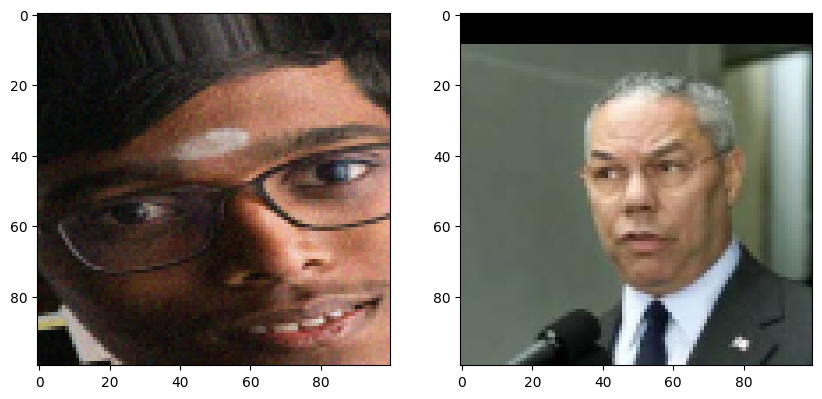

In [111]:
# Set Plot Size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [112]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [99]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                  custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [100]:
y_hat = model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]

In [101]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [91]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ imput_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ imput_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
from mtcnn import MTCNN

In [103]:
mtcnn_detector = MTCNN()

In [104]:
image = 0
def preprocessing(image, detection):
    if len(detection) == 1:
        print('input img')
        x, y, width, height = detection[0]['box']
    else:
        print('val img')
        x, y, width, height = detection['box']
    x, y = abs(x), abs(y)
    face = image[y:y+height, x:x+width]
    
    if face.shape[0] == 0 or face.shape[1] == 0:
        print(f"Invalid face region: {face.shape}")
        return None
        
    # image = tf.image.resize(face, (224, 224))
    image = tf.image.resize(face, (100,100))
    image = image / 255.0
    return  image
    # return tf.keras.applications.vgg16.preprocess_input(image)
        

In [105]:
    # input_img_path = os.path.join('test', 'test2.jpeg')
    # input_img = cv2.imread(input_img_path)
    # input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    byte_img = tf.io.read_file('test\\pragg_test.jpg')
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    input_detection = mtcnn_detector.detect_faces(np.array(img))
    img = preprocessing(img, input_detection)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
input img


In [80]:
img.numpy().max()

0.96426445

In [96]:
len(input_detection)

1

In [119]:
# OpenCV Real Time verification
def verify():

    # Specify file path for the input image
    # input_img_path = os.path.join('test', 'test2.jpeg')
    # input_img = cv2.imread(input_img_path)
    # input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    byte_img = tf.io.read_file('test\\pragg_test.jpg')
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    input_detection = mtcnn_detector.detect_faces(np.array(img))
    input_face = preprocessing(img, input_detection)
    
    # Build results array
    results = []
    for image in os.listdir(os.path.join('lfw')):
        # input_img = preprocessing(os.path.join('test', 'test2.jpeg'))
        # val_img_path = os.path.join('lfw', image)
        # val_img = cv2.imread(val_img_path)
        # val_img_rgb = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
        filename = f'lfw\\{image}'
        byte_img = tf.io.read_file(filename)
        # Load in the image
        img = tf.io.decode_jpeg(byte_img)
        val_detections = mtcnn_detector.detect_faces(np.array(img))
        # i = 1
        for detection in val_detections:
            val_img = preprocessing(img, detection)
            result = model.predict(list(np.expand_dims([input_face, val_img], axis=1)))
            # results.append(result)
            print(f"filename: {filename}, resuls: {result}")
            if result > 0.98:  # You can adjust this threshold
                print(f"Match found: {filename}, resuls: {result}")
                results.append((img,filename))

    # detection = np.sum(np.array(results) > detection_threshold)
    
    # for detection in val_detections:
    #     val_face = preprocessing(val_image, detection)
    #     if val_face is not None:
    #         result = model.predict(list(np.expand_dims([input_face, val_face], axis=1)))
    #         print(f"Image Name: {val_img_name}, resuls: {result}")
    #         if result > 0.68:  # You can adjust this threshold
    #             print(f"Match found: {val_img_name}, resuls: {result}")
    #             result_paths.append((val_img,val_img_path))
            

    #     # Make prediction
    #     result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    #     results.append(result)

    # # Detection Thresshold: Metric above a prediction is considered as positive
    # detection = np.sum(np.array(results) > detection_threshold)
    
    # # Verification Threshold: Proportion of positive predictions / total positive samples
    # verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image')))
    # verified = verification > verification_threshold

    return results
    # Verification Threshold: Proportion of positive predictions / total positive samples
    

In [120]:
results = verify()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
input img
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
val img
1/1 ━━━━━━━━━━━━━━━━━━━━ 

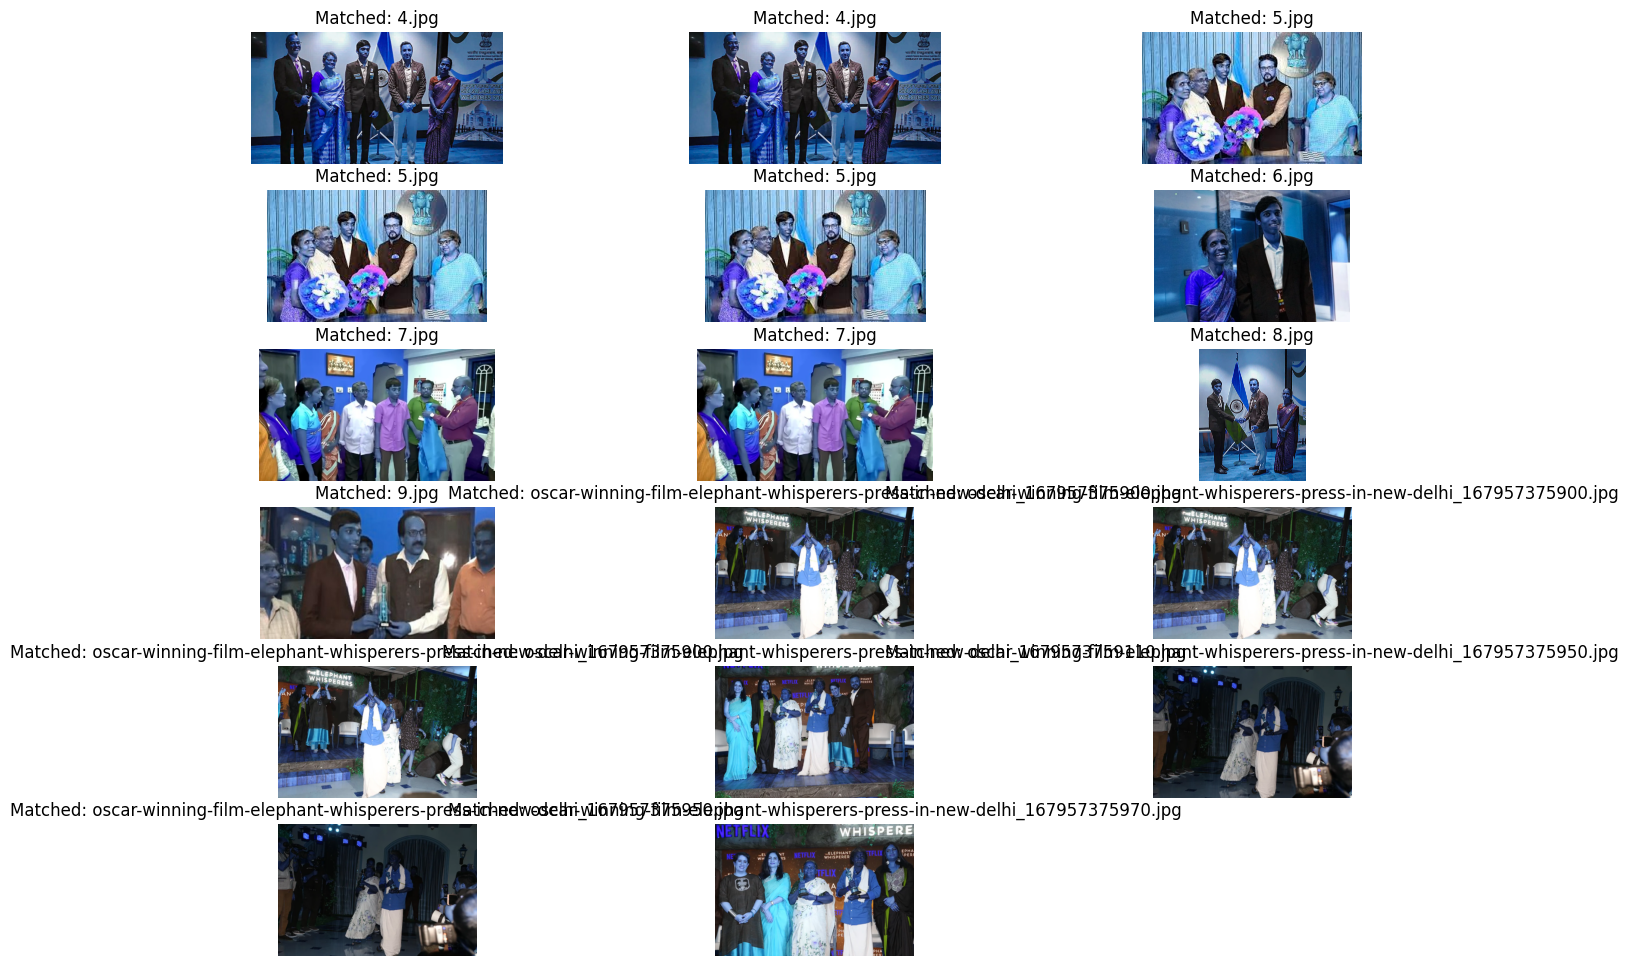

In [121]:
# Display matched images
plt.figure(figsize=(16, 12))
ncols = 3
nrows = len(results) // ncols + (len(results) % ncols != 0)

for i, (img, path) in enumerate(results):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB))
    plt.title(f'Matched: {os.path.basename(path)}')
    plt.axis('off')

In [90]:
results

[array([[1.9781799e-06]], dtype=float32),
 array([[5.5894617e-07]], dtype=float32),
 array([[0.02728097]], dtype=float32),
 array([[5.541384e-05]], dtype=float32),
 array([[1.006482e-05]], dtype=float32),
 array([[3.5504647e-07]], dtype=float32),
 array([[7.024998e-07]], dtype=float32),
 array([[6.624946e-06]], dtype=float32),
 array([[2.7184632e-07]], dtype=float32),
 array([[1.3263707e-06]], dtype=float32),
 array([[4.464975e-06]], dtype=float32),
 array([[0.00032497]], dtype=float32),
 array([[1.6210879e-05]], dtype=float32),
 array([[0.00024067]], dtype=float32),
 array([[4.095246e-06]], dtype=float32),
 array([[2.2698482e-06]], dtype=float32),
 array([[0.0044376]], dtype=float32),
 array([[3.785512e-05]], dtype=float32),
 array([[0.28050977]], dtype=float32),
 array([[0.00498396]], dtype=float32),
 array([[3.262126e-06]], dtype=float32),
 array([[2.186947e-05]], dtype=float32),
 array([[5.4028385e-07]], dtype=float32),
 array([[0.73791826]], dtype=float32),
 (<tf.Tensor: shape=(10

In [92]:
# Verification Function

In [97]:
# OpenCV Real Time verification
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))

        # Make prediction
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Thresshold: Metric above a prediction is considered as positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image')))
    verified = verification > verification_threshold

    return results, verified
    # Verification Threshold: Proportion of positive predictions / total positive samples
    

In [99]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xff == ord('v'):
        # save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87